
# CS4248 Project - Truth of Varying Shades

In [1]:
# mount drive and set working directory to be the "project" folder
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow_addons
!pip install unidecode
!pip install --upgrade tensorflow==2.11  # for compatibility

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 6.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 46.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing i

In [2]:
import re
import os
import unidecode
import string
import csv
import random
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.width', 100)
pd.set_option('max_colwidth', None)
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, make_scorer

import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Utilities

In [3]:
def plot_graphs(history, metric):
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(history.history[metric], 'r')
    plt.plot(history.history['val_' + metric], 'b')
    plt.title(f'Training and validation {metric}')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# EDA

In [4]:
FULLTRAIN_CSV = '/content/drive/MyDrive/project/raw_data/fulltrain.csv'
TEST_CSV = '/content/drive/MyDrive/project/raw_data/balancedtest.csv'
df = pd.read_csv(FULLTRAIN_CSV, names=['label', 'text'])
test = pd.read_csv(TEST_CSV, names=['label', 'text'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48854 entries, 0 to 48853
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   48854 non-null  int64 
 1   text    48854 non-null  object
dtypes: int64(1), object(1)
memory usage: 763.5+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3000 non-null   int64 
 1   text    3000 non-null   object
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [ ]:
class_cnts = df.label.value_counts()
label_to_type = {1: 'satire', 2:'hoax', 3:'propaganda', 4:'trusted'}
df['text_label'] = df.label.apply(lambda x:label_to_type[x])

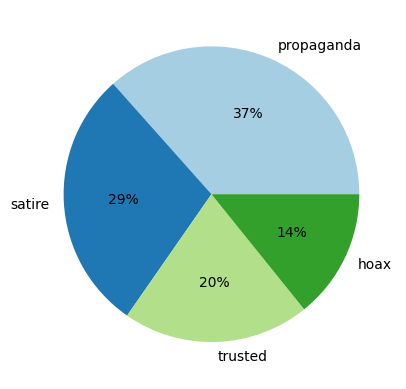

In [ ]:
palette_color = sns.color_palette('Paired')
plt.pie(class_cnts, labels=[label_to_type[i] for i in class_cnts.index], colors=palette_color, autopct='%.0f%%');

In [ ]:
df['tokenized'] = df.text.apply(lambda x: nltk.word_tokenize(x))

In [ ]:
df['num_words'] = df.tokenized.apply(len)

In [ ]:
summary = df.groupby('text_label').num_words.agg(['count', 'mean', 'median', 'std'])
summary.columns = ['#doc', '#tokens avg', '#tokens median', '#tokens std']
summary.astype('int')

,#doc,#tokens avg,#tokens median,#tokens std
text_label,,,,
hoax,6942,216,207,89
propaganda,17870,1018,765,1638
satire,14047,338,184,294
trusted,9995,506,389,411


## Hyperparameters

In [5]:
# used to test different hyper parameters

EMBEDDING_DIM = 100  # Dimension of the dense embedding. Defaults to 100
MAXLEN = 1000  # Maximum length of all sequences. Defaults to 1000.


# training
BATCH_SIZE = 64

## Data pipeline

The dataset is provided in a csv file. Each row of this file contains the following values separated by commas:
- label: the class label of the text
- text: the text content

In [6]:
def preprocess_text(text):
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '' , text)
    # remove accented characters from text, e.g. café
    text = unidecode.unidecode(text)
    # tested some other preprocessing steps, but no big difference
    return text

In [7]:
def prepare_dataset(file_path):
    # load data
    fulltrain = pd.read_csv(FULLTRAIN_CSV, names=['label', 'text'])
    sentences, labels = fulltrain.text, fulltrain.label - 1  # -1 to make labels 0-index
    print(f"Found {len(sentences)} examples.\n")
    
    sentences = sentences.apply(preprocess_text)
    labels = pd.get_dummies(labels)
    print(f"Label of first example: {labels.iloc[0].tolist()}")
    print(f"Text of first example:\n'{sentences[0]}'\n")
    
    # split dataset into train and validation
    train_sentences, val_sentences, train_labels, val_labels = train_test_split(
        sentences, labels, test_size=0.1, shuffle=True, stratify=labels, random_state=42)
    print('After train val split:')
    print(f"There are {len(train_sentences)} examples for training.")
    print(f"There are {len(val_sentences)} examples for validation.\n")
    
    # data pipeline
    train = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))\
        .cache()\
        .shuffle(10 * BATCH_SIZE)\
        .batch(BATCH_SIZE)\
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    val = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels))\
        .cache()\
        .shuffle(10 * BATCH_SIZE)\
        .batch(BATCH_SIZE)\
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    return train, val

In [8]:
train_dataset, val_dataset = prepare_dataset(FULLTRAIN_CSV)

Found 48854 examples.

Label of first example: [1, 0, 0, 0]
Text of first example:
'A little less than a decade ago hockey fans were blessed with a slate of games every night but on Thursday sources confirmed that for the ninth consecutive year NHL players have been locked out with very slim hopes of an agreement in sight It seems like just yesterday Martin St Louis and his Lightning teammates were raising the Stanley Cup high school hockey coach and onetime ESPN analyst Barry Melrose said Obviously Im still hoping the two sides can come together and reach an agreement but Im starting to think nobody really misses hockey anymore Nope Nobody but old Barry Id still love to catch an Atlanta Thrashers game Observers have noted that when arena doors do reopen the NHL will face the perhaps greater challenge of convincing fans to return to hockey instead of watching more popular sports like football basketball baseball and SlamBall '

After train val split:
There are 43968 examples for traini

In [9]:
# prepare test dataset
sentences, labels = test.text, test.label - 1  # -1 to make labels 0-index
labels = pd.get_dummies(labels)
test = tf.data.Dataset.from_tensor_slices((sentences, labels))\
    .cache()\
    .shuffle(10 * BATCH_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

## Tokenization

In [10]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    ngrams=None,
    output_mode='int',
    output_sequence_length=MAXLEN
)
tokenizer.adapt(train_dataset.map(lambda text, label: text))

vocab = tokenizer.get_vocabulary(include_special_tokens=True)
VOCAB_SIZE = tokenizer.vocabulary_size()

print(f"Vocabulary contains {VOCAB_SIZE} words.")
print(f"First 20 words in the vocabulary: {vocab[:20]}")
print(f"Index of unknown token is {vocab.index('[UNK]')}.")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Vocabulary contains 303127 words.
First 20 words in the vocabulary: ['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'that', 'is', 'for', 'on', 'it', 'as', 'with', 'are', 'be', 'this', 'was', 'have']
Index of unknown token is 1.


## Prepare pre-defined Embeddings

We here use the 6B & 100d version of [GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford.

In [11]:
GLOVE_FILE = './glove.6B.100d.txt'

GLOVE_EMBEDDINGS = {} # Initialize an empty embeddings index dictionary

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE, EMBEDDING_DIM)) 

for i, word in enumerate(vocab):  # iterate over each word in the vocabulary
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

# Since the original GLOVE doesn't have an embedding for [UNK], let's make it the mean of all embeddings.
# According to Pennington: "I've found that just taking an average of all or a subset of the word vectors produces a good unknown vector."
EMBEDDINGS_MATRIX[vocab.index('[UNK]')] = EMBEDDINGS_MATRIX.mean(axis=0) 

## Bi-LSTM

In [12]:
def create_model(embedding_dim, maxlen, embeddings_matrix=None, unit=None, finetune_embedding=False):
    """create a basic bidirectional rnn with specified rnn/lstm/gru unit and whether to finetune embeddings or not
       params:
           unit: str, one of 'rnn', 'lstm', 'gru', default rnn
           fintune_embedding: bool, whether to finetune pretrained embedding, default False
       return:
           the text classifier model
    """
    if unit == 'lstm':
        cell = tf.keras.layers.LSTM(64)
    elif unit == 'gru':
        cell = tf.keras.layers.GRU(64)
    else:
        cell = tf.keras.layers.RNN(64)
        
    model = tf.keras.Sequential([
        tokenizer,  # text vectorization layer
        tf.keras.layers.Embedding(
            input_dim=tokenizer.vocabulary_size(),
            output_dim=embedding_dim,
            weights=embeddings_matrix,
            trainable=finetune_embedding,
            #mask_zero=True  # to handle variable sequence lengths
        ),
        tf.keras.layers.Bidirectional(cell),
        tf.keras.layers.Dense(64, activation='relu'),  # test different # hidden units here 64/128/256
        #tf.keras.layers.Dropout(0.2),
        #tf.keras.layers.Dense(32, activation='relu')
        tf.keras.layers.Dense(4)
    ])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy', F1Score(num_classes=4, average='macro')]) 

    return model

In [ ]:
# basic lstm, without finetuing pretrained embeddings
lstm_base = create_model(EMBEDDING_DIM, MAXLEN, [EMBEDDINGS_MATRIX], 'lstm', False)
lstm_base_checkpoint_path = "./checkpoints/lstm_base_checkpoint"
#lstm_base_checkpoint_path = "./checkpoints/lstm_base_checkpoint_128h"

print(lstm_base.summary())

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=lstm_base_checkpoint_path, 
                                                save_weights_only=True, 
                                                save_best_only=True,
                                                verbose=1)
# train 
try:
    lstm_base.load_weights(lstm_base_checkpoint_path)
    print('Weights loaded successfully.')
except:
    history = lstm_base.fit(train_dataset, 
                            epochs=100,
                            validation_data=val_dataset,
                            callbacks=[early_stopping, checkpoint])
    
# evaluate 
loss, accuracy, f1 = lstm_base.evaluate(val_dataset)
print(f'Validation Loss: {loss}, Accuracy: {accuracy}, F1: {f1}')

# evaluate on test
loss, accuracy, f1 = lstm_base.evaluate(test)
print(f'Test Loss: {loss}, Accuracy: {accuracy}, F1: {f1}')


# dump history object
# with open('./history/lstm_base_history.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1000)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 1000, 100)         30312700  
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 30,405,696
Trainable params: 92,996
Non-

77/77 [==============================] - 5s 35ms/step - loss: 0.0957 - accuracy: 0.9673 - f1_score: 0.9648
Validation Loss: 0.09569186717271805, Accuracy: 0.9672533869743347, F1: 0.9648305177688599
47/47 [==============================] - 2s 45ms/step - loss: 1.9998 - accuracy: 0.5920 - f1_score: 0.5726
Test Loss: 1.9997599124908447, Accuracy: 0.5920000076293945, F1: 0.5725545287132263


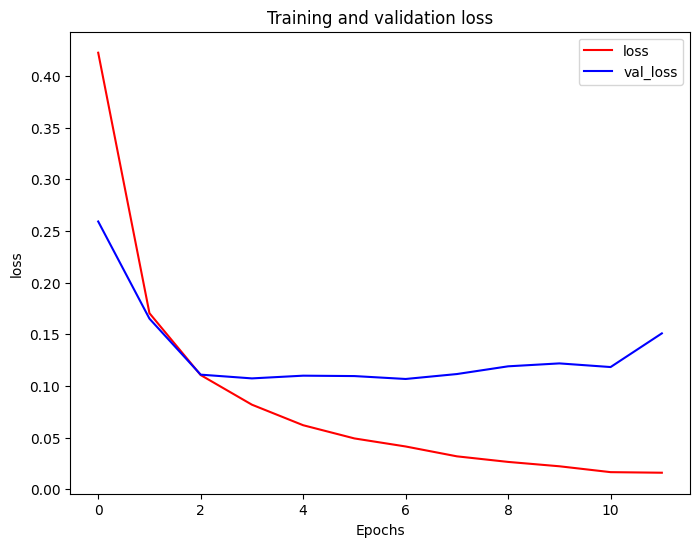

In [ ]:
plot_graphs(history, 'loss')

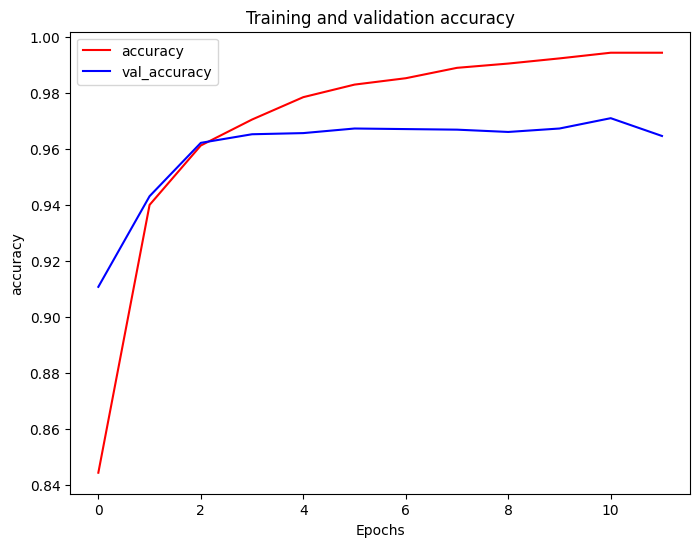

In [ ]:
plot_graphs(history, 'accuracy')

In [13]:
# fintuned lstm
lstm_finetune = create_model(EMBEDDING_DIM, MAXLEN, [EMBEDDINGS_MATRIX], 'lstm', True)
lstm_finetune_checkpoint_path = "./checkpoints/lstm_finetune_checkpoint"
#lstm_finetune_checkpoint_path = "./checkpoints/lstm_finetune_checkpoint_128h"
print(lstm_finetune.summary())

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=lstm_finetune_checkpoint_path, 
                                                save_weights_only=True, 
                                                save_best_only=True,
                                                verbose=1)
# train
try:
    lstm_finetune.load_weights(lstm_finetune_checkpoint_path)
    print('Weights restored successfully')
except:
    history = lstm_finetune.fit(train_dataset, 
                                epochs=100,
                                validation_data=val_dataset,
                                callbacks=[early_stopping, checkpoint])
# evaluate
loss, accuracy, f1 = lstm_finetune.evaluate(val_dataset)
print(f'Loss: {loss}, Accuracy: {accuracy}, F1: {f1}')

# evaluate on test
loss, accuracy, f1 = lstm_finetune.evaluate(test)
print(f'Test Loss: {loss}, Accuracy: {accuracy}, F1: {f1}')

# dump history object
# with open('./history/lstm_finetune_history.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1000)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1000, 100)         30312700  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 30,405,696
Trainable params: 30,405,696
No

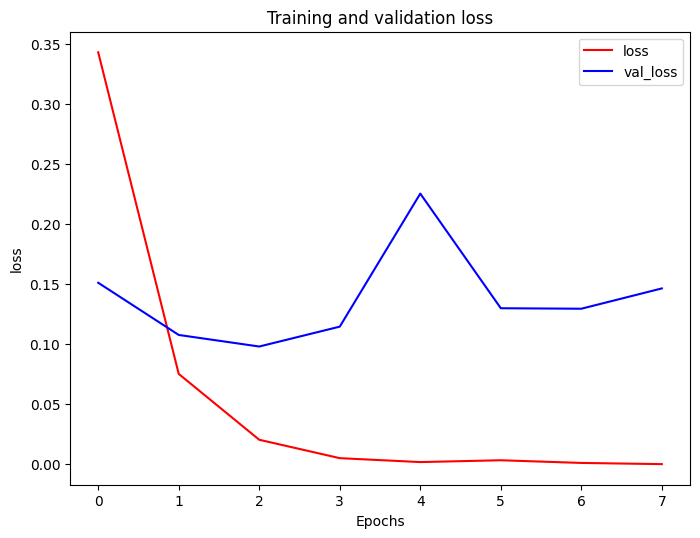

In [ ]:
plot_graphs(history, 'loss')

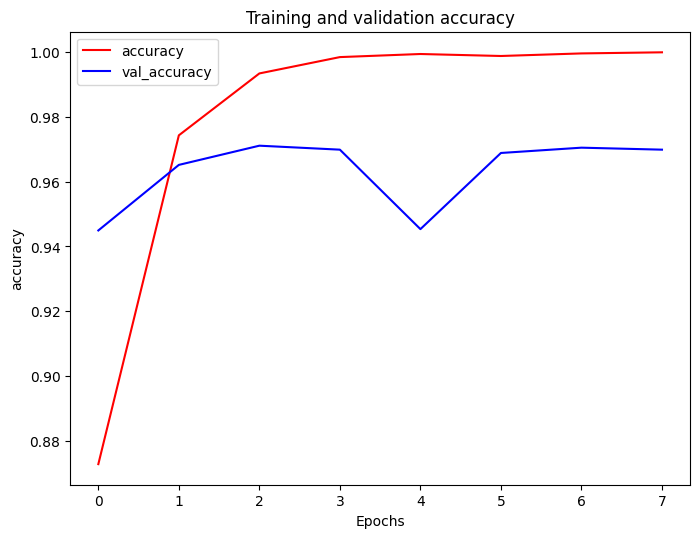

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
val_loss = history.history['val_loss']
slope, *_ = linregress(range(len(val_loss)), val_loss)
print(f"The slope of validation loss curve is {slope:.5f}")

The slope of validation loss curve is 0.00337


## BERT

In [14]:
!pip install -q -U "tensorflow-text==2.11.*"
!pip install tf-models-official==2.11.0  # to use AdamW optimizer
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 80.4 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=d4473c6399edcdbe84f6c34c275a88a89db654df812883dcab51bb7f09809549
  Stored in directory: /root/.cache/pip/wheels/e2/a5/92/2c80d19287

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

In [16]:
# there are many pretrained BERT models available
## Small BERT: same general architecture but fewer Transformer blocks, tradeoff between speed and quality
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

In [17]:
adamw = tf.keras.optimizers.experimental.AdamW

In [21]:
def build_classifier_model():
    # create layers
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # specify input
    encoder_inputs = preprocessing_layer(text_input)  # pass through preprocessing layer
    outputs = encoder(encoder_inputs)  # pass through BERT encoder
    o = outputs['pooled_output']  # (B, H), get the embedding of the entire text input
    o = tf.keras.layers.Dropout(0.1)(o)  # prevent overfitting
    o = tf.keras.layers.Dense(100, activation='relu')(o)
    o = tf.keras.layers.Dropout(0.1)(o)  # prevent overfitting
    o = tf.keras.layers.Dense(4, name='classifier')(o)
    bert_model = tf.keras.Model(text_input, o)

    bert_model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy', F1Score(num_classes=4, average='macro')],
        optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=3e-5)  # small lr required for finetuning
        )
    return bert_model

In [22]:
epochs = 5
steps_per_epoch = train_dataset.cardinality().numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5 # need to be sufficiently small for finetuning
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1


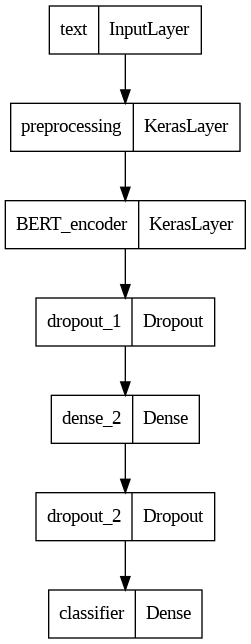

Epoch 1/100
687/687 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.9218 - f1_score: 0.9158
Epoch 1: val_loss improved from inf to 0.09250, saving model to ./checkpoints/small_bert_checkpoint2
687/687 [==============================] - 474s 663ms/step - loss: 0.2178 - accuracy: 0.9218 - f1_score: 0.9158 - val_loss: 0.0925 - val_accuracy: 0.9642 - val_f1_score: 0.9612
Epoch 2/100
687/687 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9814 - f1_score: 0.9799
Epoch 2: val_loss improved from 0.09250 to 0.05736, saving model to ./checkpoints/small_bert_checkpoint2
687/687 [==============================] - 446s 649ms/step - loss: 0.0566 - accuracy: 0.9814 - f1_score: 0.9799 - val_loss: 0.0574 - val_accuracy: 0.9808 - val_f1_score: 0.9786
Epoch 3/100
687/687 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9906 - f1_score: 0.9898
Epoch 3: val_loss improved from 0.05736 to 0.04447, saving model to ./checkpoints/small_bert

In [23]:
print(f'Training model with {tfhub_handle_encoder}')
small_bert = build_classifier_model()
display(tf.keras.utils.plot_model(small_bert))

#mall_bert_checkpoint_path = "./checkpoints/small_bert_checkpoint"
small_bert_checkpoint_path = "./checkpoints/small_bert_checkpoint2"

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=small_bert_checkpoint_path, 
                                                save_weights_only=True, 
                                                save_best_only=True,
                                                verbose=1)
try:
    small_bert.load_weights(small_bert_checkpoint_path)
    print('Weights loaded successfully.')
except:
    history = small_bert.fit(x=train_dataset,
                             validation_data=val_dataset,
                             epochs=100,
                             callbacks=[early_stopping, checkpoint])
    
# evaluate
loss, accuracy, f1 = small_bert.evaluate(val_dataset)
print(f'Validation Loss: {loss}, Accuracy: {accuracy}, F1: {f1}')

# evaluate on test
loss, accuracy, f1 = small_bert.evaluate(test)
print(f'Test Loss: {loss}, Accuracy: {accuracy}, F1: {f1}')


# dump history object
# with open('./history/small_bert_history.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

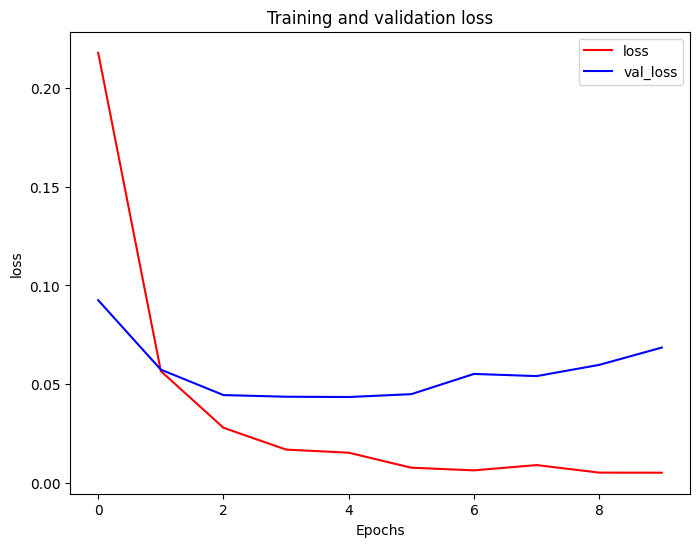

In [24]:
plot_graphs(history, 'loss')

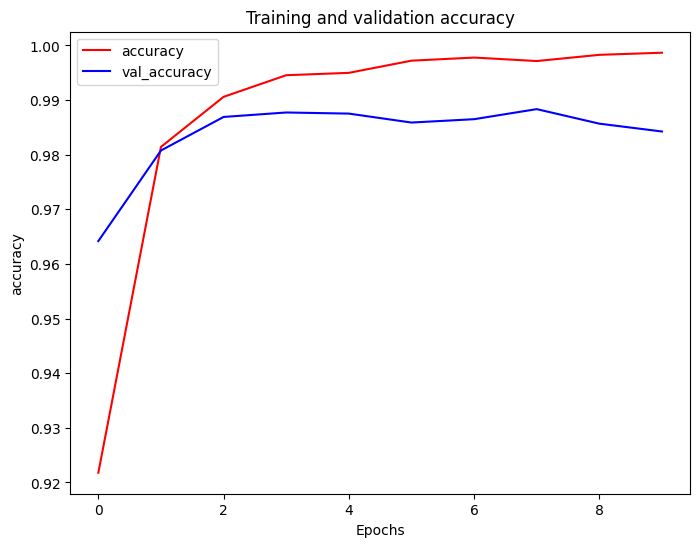

In [25]:
plot_graphs(history, 'accuracy')